# SEGMENTATION OF HIPPOCAMPUS

# 1. Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd gdrive/MyDrive/Segmentation_of_Hippocampus/

/content/gdrive/MyDrive/Segmentation_of_Hippocampus


# 2. Importing Libraries

In [ ]:
!pip install nibabel

In [ ]:
!pip install split-folders

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imsave
import nibabel as nib
import glob
import random
import splitfolders

from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from keras.models import load_model

# 3. Exploring the Data

In [ ]:
scaler = MinMaxScaler()

In [ ]:
TRAIN_DATASET_PATH = '/content/gdrive/MyDrive/Segmentation_of_Hippocampus/Task04_Hippocampus/imagesTr'
MASK_DATASET_PATH = '/content/gdrive/MyDrive/Segmentation_of_Hippocampus/Task04_Hippocampus/labelsTr'
TEST_DATASET_PATH = '/content/gdrive/MyDrive/Segmentation_of_Hippocampus/Task04_Hippocampus/imagesTs'

In [ ]:
test_image=nib.load(TRAIN_DATASET_PATH + '/hippocampus_001.nii.gz').get_fdata()
print(test_image.max())
print(test_image.shape)

139.0
(35, 51, 35)


In [ ]:
test_image = scaler.fit_transform(test_image.reshape(-1, test_image.shape[-1])).reshape(test_image.shape)

In [ ]:
print(test_image.max())
print(test_image.shape)

1.0
(35, 51, 35)


In [ ]:
# temp_img=test_image[:16, :16, :16]
# temp_img = np.stack((temp_img,)*3, axis=-1)
# #temp_img=np.expand_dims(temp_img, axis=-1)
# print(temp_img.shape)

In [ ]:
def resize_volume(img, desired_depth, desired_width, desired_height):

    current_depth = img.shape[0]
    current_width = img.shape[1]
    current_height = img.shape[2]

    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height

    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = zoom(img, (depth_factor, width_factor, height_factor), order=1)
    return img

In [ ]:
desired_depth = 64
desired_width = 64
desired_height = 64

In [ ]:
test_image = resize_volume(test_image, desired_depth, desired_width, desired_height)

In [ ]:
print(test_image.max())
print(test_image.shape)

1.0
(64, 64, 64)


In [ ]:
test_mask=nib.load(MASK_DATASET_PATH + '/hippocampus_001.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

In [ ]:
print(np.unique(test_mask))

[0 1 2]


In [ ]:
print(test_mask.max())
print(test_mask.shape)

2
(35, 51, 35)


In [ ]:
# temp_mask=test_mask[:16, :16, :16]
# temp_mask = np.expand_dims(temp_mask, axis=-1)
# print(temp_mask.shape)

In [ ]:
test_mask = resize_volume(test_mask, desired_depth, desired_width, desired_height)

In [ ]:
print(test_mask.max())
print(test_mask.shape)

2
(64, 64, 64)


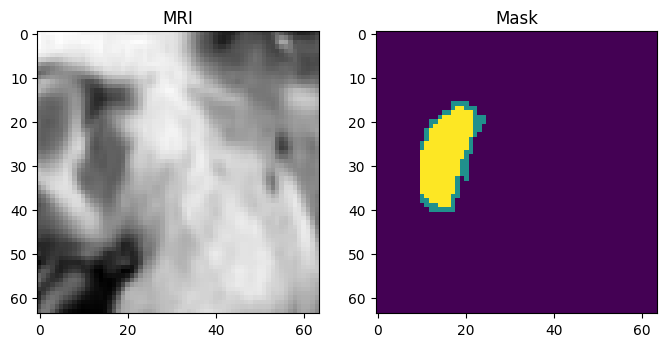

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.imshow(test_image[:,:,n_slice], cmap='gray')
plt.title('MRI')
plt.subplot(1,2,2)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
test_img = np.stack((test_image,)*3, axis=-1)
print(test_img.shape)

(64, 64, 64, 3)


In [ ]:
test_mask = np.expand_dims(test_mask, axis=-1)
print(test_mask.shape)

(64, 64, 64, 1)


# 4. Data Preprocessing

In [ ]:
mri_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/hippocampus_*.nii.gz'))
mask_list = sorted(glob.glob(MASK_DATASET_PATH + '/hippocampus_*.nii.gz'))

In [ ]:
print(len(mri_list))
print(len(mask_list))

260
260


In [ ]:
test_mri_list = sorted(glob.glob(TEST_DATASET_PATH + '/hippocampus_*.nii.gz'))
print(len(test_mri_list))

130


In [ ]:
for img in range(len(mri_list)):
  temp_img = nib.load(mri_list[img]).get_fdata()
  temp_img = scaler.fit_transform(temp_img.reshape(-1, temp_img.shape[-1])).reshape(temp_img.shape)

  temp_mask = nib.load(mask_list[img]).get_fdata()
  temp_mask = temp_mask.astype(np.uint8)

  temp_img=resize_volume(temp_img, desired_depth, desired_width, desired_height)
  temp_img = np.stack((temp_img,)*3, axis=-1)
  temp_mask=resize_volume(temp_mask, desired_depth, desired_width, desired_height)
  temp_mask=np.expand_dims(temp_mask, axis=-1)

  val, counts = np.unique(temp_mask, return_counts=True)

  if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        # print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=3)
        np.save('v2_dataset/images/image_'+str(img)+'.npy', temp_img)
        np.save('v2_dataset/masks/mask_'+str(img)+'.npy', temp_mask)

  # else:
  #     # print("I am useless")

In [ ]:
# Splitting Dataset into training and validation
input_folder = 'v2_dataset/'
output_folder = 'v2_Data'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

Copying files: 520 files [00:26, 19.42 files/s]


# 5. Creating Custom Data Generator

In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)
            # print(image.shape)

            images.append(image)
    images = np.array(images)

    return(images)

In [ ]:
train_img_dir = "v2_Data/train/images/"
train_img_list = os.listdir(train_img_dir)

In [ ]:
arr = load_img(train_img_dir, train_img_list[0:64])

In [ ]:
print(arr[0].shape)

(64, 64, 64, 3)


In [ ]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

# 4. Creating Model

In [ ]:
kernel_initializer =  'he_uniform'

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

# 5. Training the Model

In [ ]:
train_img_dir = "v2_Data/train/images/"
train_mask_dir = "v2_Data/train/masks/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

In [ ]:
val_img_dir = "v2_Data/val/images/"
val_mask_dir = "v2_Data/val/masks/"

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [ ]:
batch_size = 8

In [ ]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
metrics = ['accuracy']
loss = tf.keras.losses.CategoricalCrossentropy()
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [ ]:
model = simple_unet_model(IMG_HEIGHT=64,
                          IMG_WIDTH=64,
                          IMG_DEPTH=64,
                          IMG_CHANNELS=3,
                          num_classes=3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 64, 3)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 64, 64, 64, 16)       1312      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 64, 64, 64, 16)       0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 64, 64, 64, 16)       6928      ['dropout[0][0]']             
                                                                                              

In [ ]:
model.compile(optimizer = optim, loss=loss, metrics=metrics)

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
model.save('3d_unet_v2.hdf5')

Epoch 1/100
24/24 [==============================] - 21s 877ms/step - loss: 0.5569 - accuracy: 0.8986 - val_loss: 0.3962 - val_accuracy: 0.9418
Epoch 2/100
24/24 [==============================] - 22s 934ms/step - loss: 0.2316 - accuracy: 0.9409 - val_loss: 0.2297 - val_accuracy: 0.9417
Epoch 3/100
24/24 [==============================] - 16s 658ms/step - loss: 0.1444 - accuracy: 0.9412 - val_loss: 0.2017 - val_accuracy: 0.9417
Epoch 4/100
24/24 [==============================] - 14s 601ms/step - loss: 0.1314 - accuracy: 0.9415 - val_loss: 0.1619 - val_accuracy: 0.9417
Epoch 5/100
24/24 [==============================] - 13s 568ms/step - loss: 0.1255 - accuracy: 0.9414 - val_loss: 0.1689 - val_accuracy: 0.9417
Epoch 6/100
24/24 [==============================] - 13s 539ms/step - loss: 0.1213 - accuracy: 0.9415 - val_loss: 0.1628 - val_accuracy: 0.9417
Epoch 7/100
24/24 [==============================] - 13s 550ms/step - loss: 0.1159 - accuracy: 0.9415 - val_loss: 0.1631 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 6. Saving and Evaluating the Model

In [ ]:
# Optionally, save the trained model
# model.save("unet_model_v2.h5")

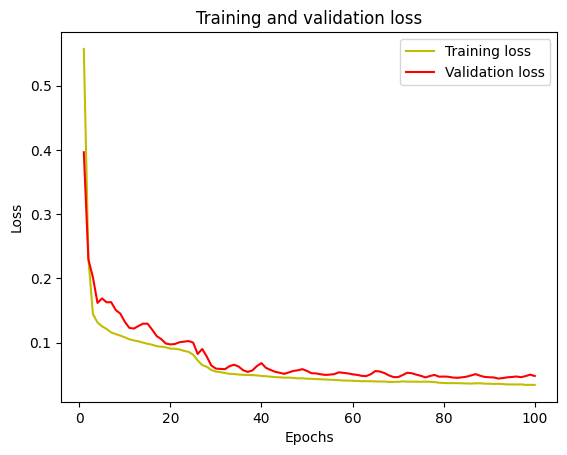

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

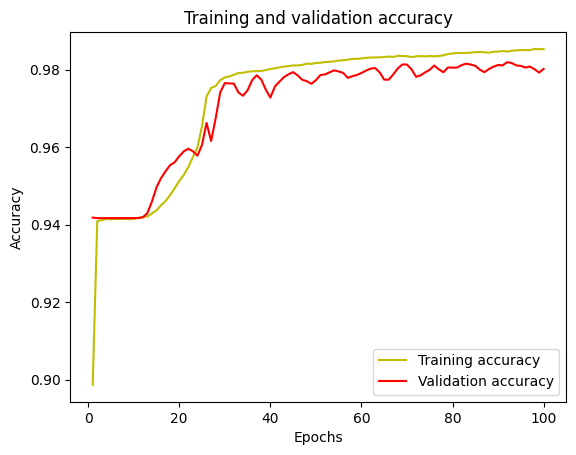

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 7. Testing the Model

In [ ]:
for img in range(len(test_mri_list)):
  temp_img = nib.load(test_mri_list[img]).get_fdata()

  temp_img=resize_volume(temp_img, desired_depth, desired_width, desired_height)
  temp_img = np.stack((temp_img,)*3, axis=-1)
  np.save('v2_testing/image_'+str(img)+'.npy', temp_img)

NameError: ignored

In [ ]:
my_model = load_model('3d_unet_v2.hdf5')

In [ ]:
for i in range(0,129):
  img_path = "v2_testing/image_" + str(i) + ".npy"
  if os.path.exists(img_path):
    test_img = np.load(img_path)

    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
    slice_indices = [10, 20, 30 ,40 ,50 ,60]
    for j, a in enumerate(axes.flatten()):
      if j < len(slice_indices):
        mri_slice = test_img[:, slice_indices[j], :, 1]
        a.imshow(mri_slice)
        a.axis("off")
    save_path = "Images/image_" + str(i) + ".png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

In [ ]:
for i in range(0,129):
  img_path = "v2_testing/image_" + str(i) + ".npy"
  if os.path.exists(img_path):
    test_img = np.load(img_path)
    test_img_input = np.expand_dims(test_img, axis=0)
    test_prediction = my_model.predict(test_img_input)
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
    slice_indices = [10, 20, 30 ,40 ,50 ,60]
    for j, a in enumerate(axes.flatten()):
      if j < len(slice_indices):
        mri_slice = test_prediction_argmax[:, slice_indices[j], :]
        a.imshow(mri_slice)
        a.axis("off")
    save_path = "predictions/image_" + str(i) + ".png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

1/1 [==============================] - 0s 29ms/step


In [ ]:
test_img = np.load("v2_testing/image_13.npy")

In [ ]:
test_img_input = np.expand_dims(test_img, axis=0)

In [ ]:
test_prediction = my_model.predict(test_img_input)

1/1 [==============================] - 9s 9s/step


In [ ]:
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

In [ ]:
test_img.shape

(64, 64, 64, 3)

In [ ]:
test_prediction.shape

(1, 64, 64, 64, 3)

In [ ]:
test_prediction_argmax.shape

(64, 64, 64)

In [ ]:
type(test_prediction_argmax)

numpy.ndarray

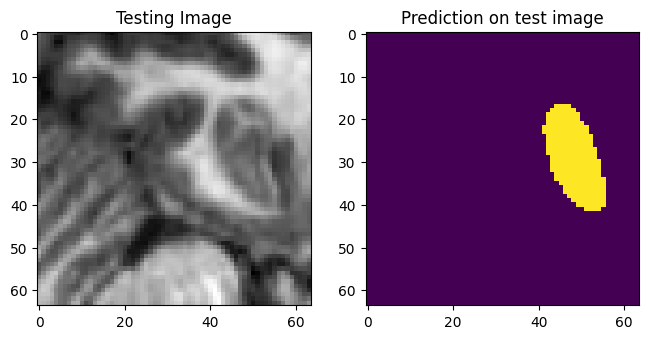

In [ ]:
#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = random.randint(0,15)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

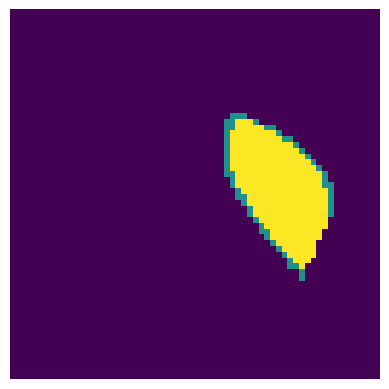

In [ ]:
# Initialize figure and axes
fig, ax = plt.subplots()
# Plot slice(s) of volume
mri_slice = test_prediction_argmax[:,10,:]
ax.imshow(mri_slice)
# Edit axes and display figure
ax.axis("off")
plt.show()

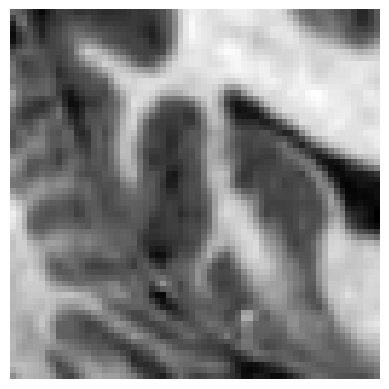

In [ ]:
# Initialize figure and axes
fig, ax = plt.subplots()
# Plot slice(s) of volume
mri_slice = test_img[:,10,:,1]
ax.imshow(mri_slice, cmap='gray')
# Edit axes and display figure
ax.axis("off")
plt.show()

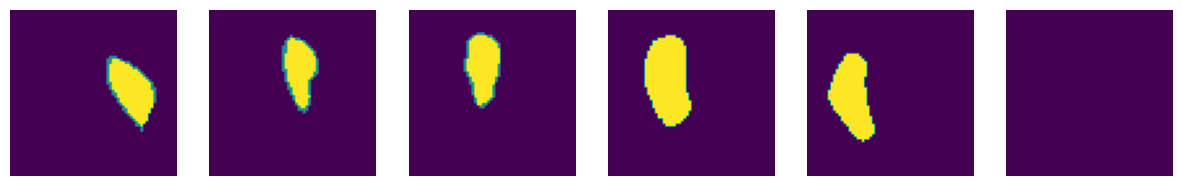

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
slice_indices = [10, 20, 30 ,40 ,50 ,60]

for i, a in enumerate(axes.flatten()):
  if i < len(slice_indices):
    mri_slice = test_prediction_argmax[:, slice_indices[i], :]
    a.imshow(mri_slice)
    a.axis("off")

plt.show()

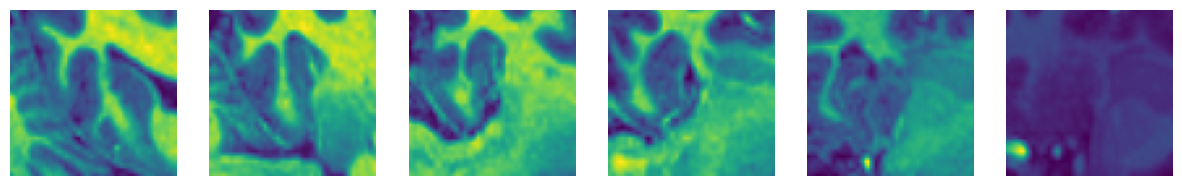

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,15))
slice_indices = [10, 20, 30 ,40 ,50 ,60]

for i, a in enumerate(axes.flatten()):
  if i < len(slice_indices):
    mri_slice = test_img[:, slice_indices[i], :, 1]
    a.imshow(mri_slice)
    a.axis("off")

plt.show()

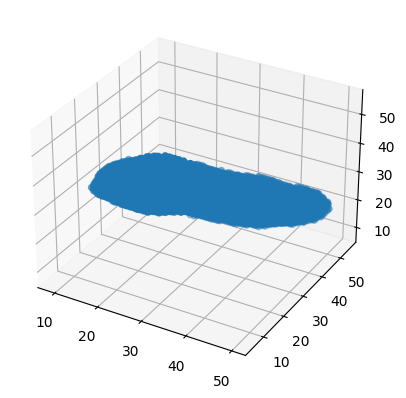

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Get the 3D coordinates of non-zero values in the array
x, y, z = np.where(test_prediction_argmax > 0)

# Plot the points
ax.scatter(x, y, z)

# Show the plot
plt.show()

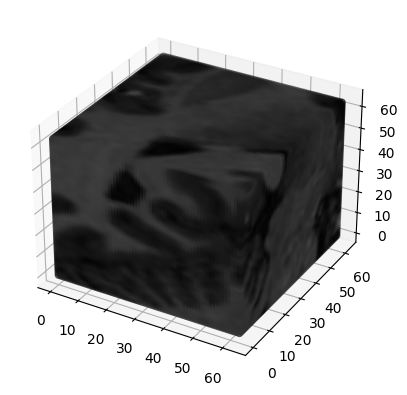

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Normalize the RGB values to be within 0-1 range
test = test_img / np.max(test_img)


# Create a figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Get the 3D coordinates of non-zero values in the array
x, y, z = np.where(np.any(test > 0, axis=3))

# Get the corresponding colors
colors = test[x,y,z]

# Plot the points with their corresponding colors
ax.scatter(x, y, z, c=colors)

# Show the plot
plt.show()